[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/var/folders/wg/n_m4x7tj7772052pr5k0sz0r0000gn/T/ipykernel_57545/325473253.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this w

                    count    mean     std  Skewness  Kurtosis  KS_pvalue  \
Ticker VolumeGroup                                                         
AFLT   Low            497 -0.0004  0.0118   -0.3991    3.0278     0.1018   
       Medium         496  0.0002  0.0173    0.4626    0.7124     0.0479   
       High           512  0.0025  0.0303    0.2698    4.8451     0.0261   
GAZP   Low            497 -0.0001  0.0090    0.1409    0.0956     0.7695   
       Medium         496 -0.0005  0.0128    0.4229    1.0276     0.2718   
       High           512  0.0022  0.0222    0.6027    4.7314     0.3358   
LKOH   Low            497  0.0010  0.0091    0.4257    2.4724     0.6276   
       Medium         496  0.0002  0.0131   -0.0421   -0.0137     0.9973   
       High           512  0.0012  0.0271   -0.6038    8.3231     0.0939   
PLZL   Low            497 -0.0005  0.0126    0.2306    4.9101     0.0000   
       Medium         496  0.0034  0.0226    0.8749    6.5002     0.0000   
       High 

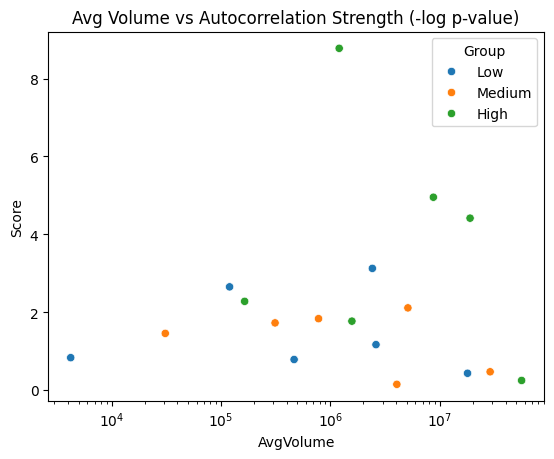

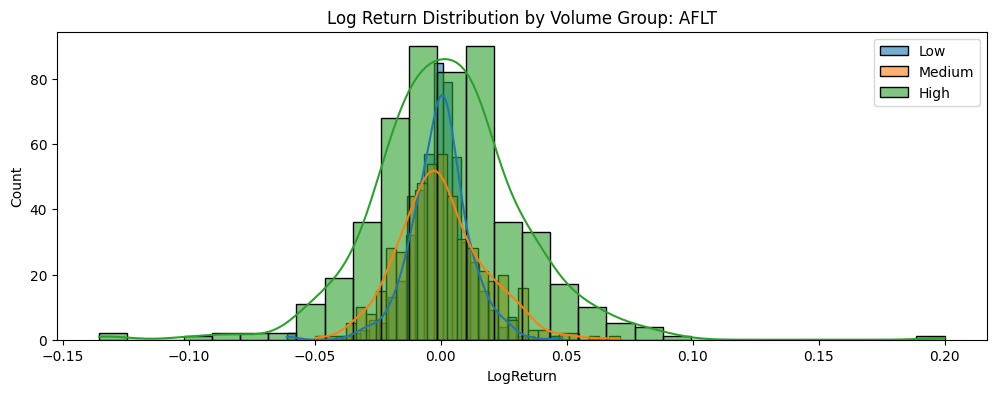

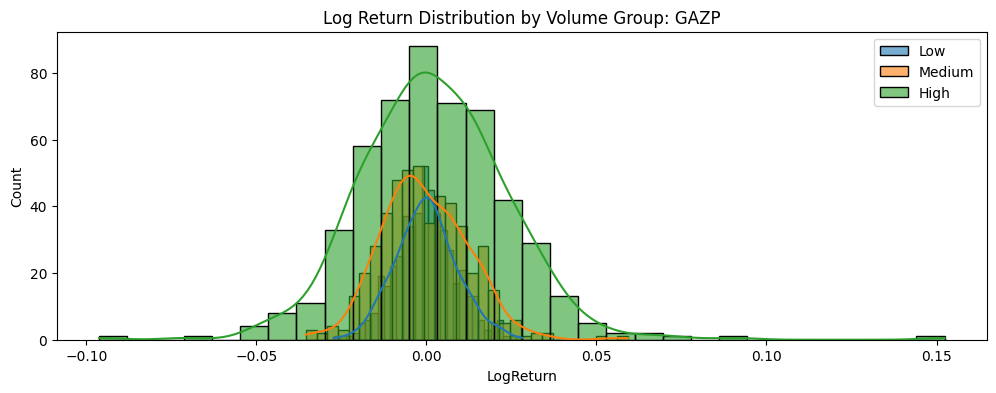

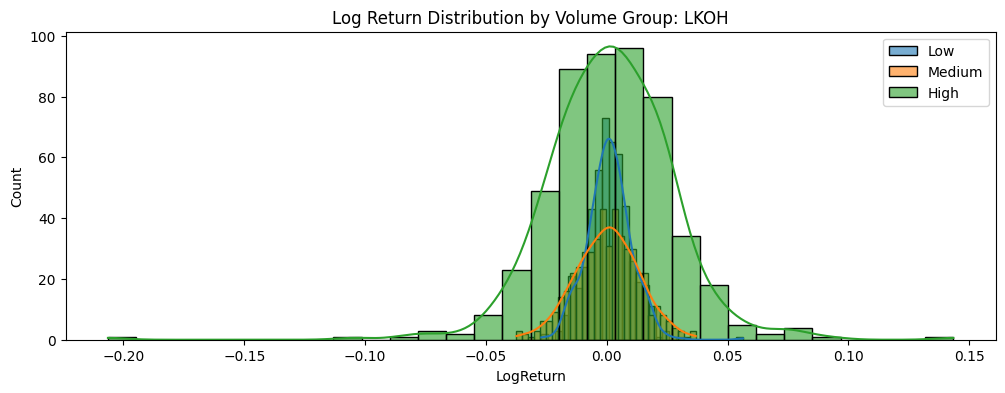

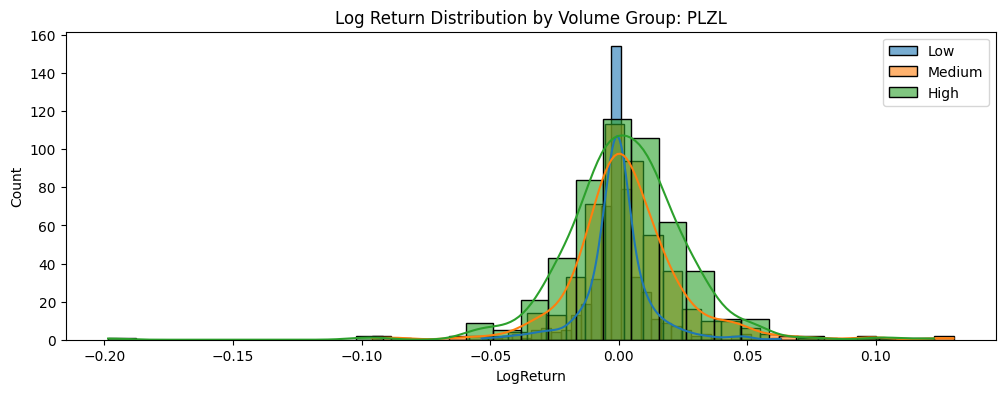

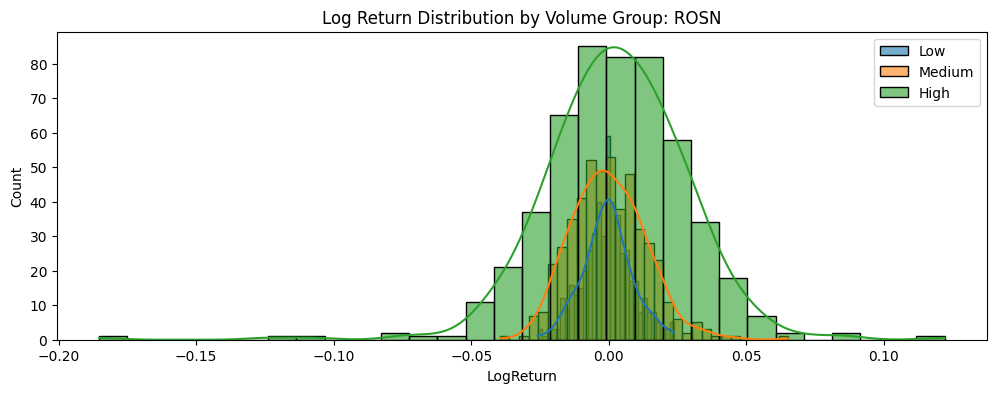

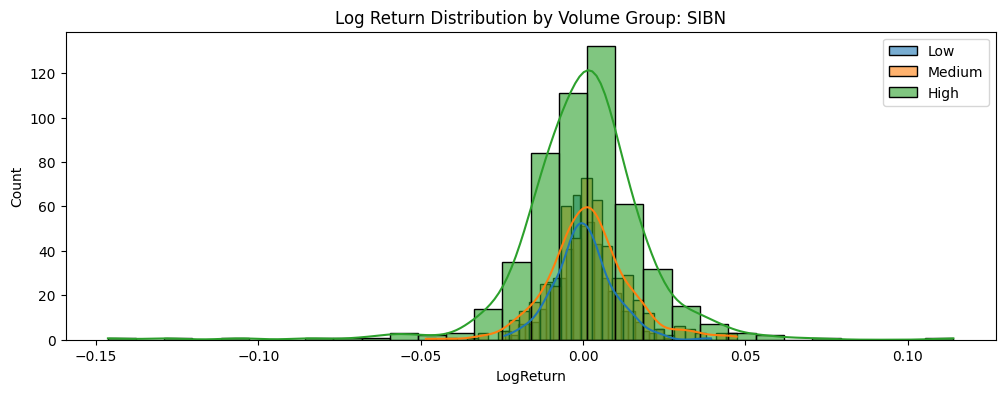

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


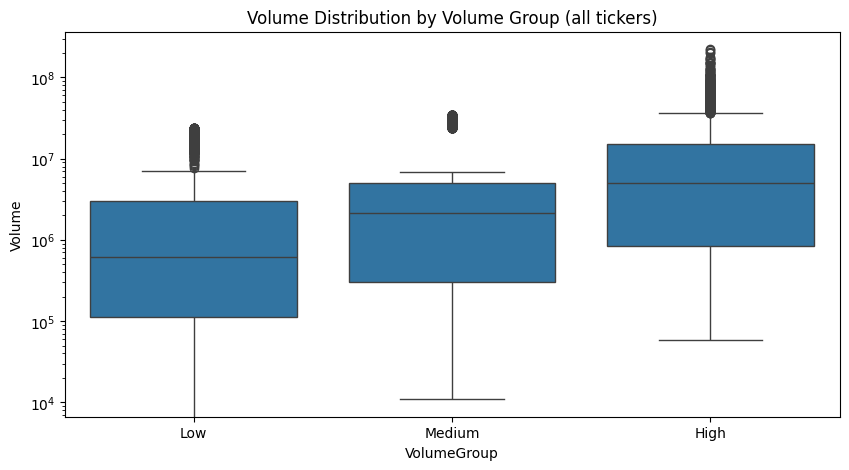

/var/folders/wg/n_m4x7tj7772052pr5k0sz0r0000gn/T/ipykernel_57545/325473253.py:112: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vol_vs_vol = df.groupby(['Ticker', 'VolumeGroup']).agg(


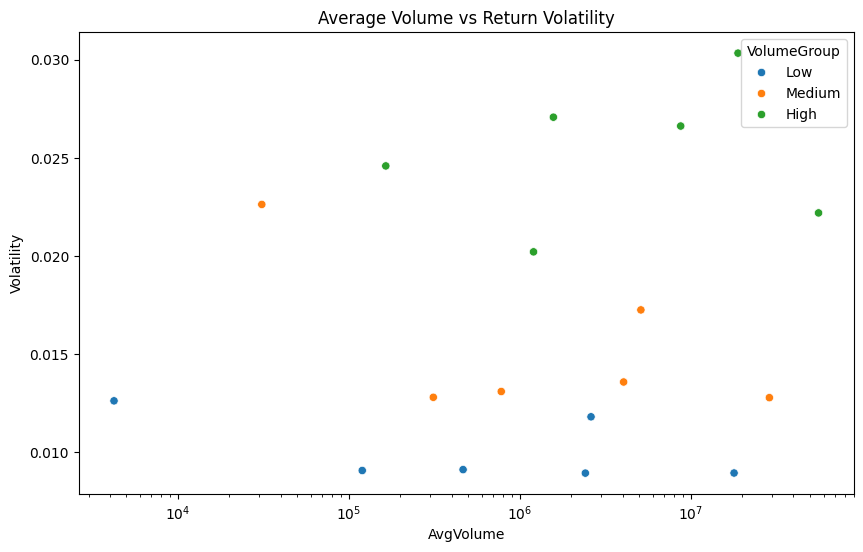

ADF statistic: -17.114730228246774
p-value: 7.32480838153743e-30


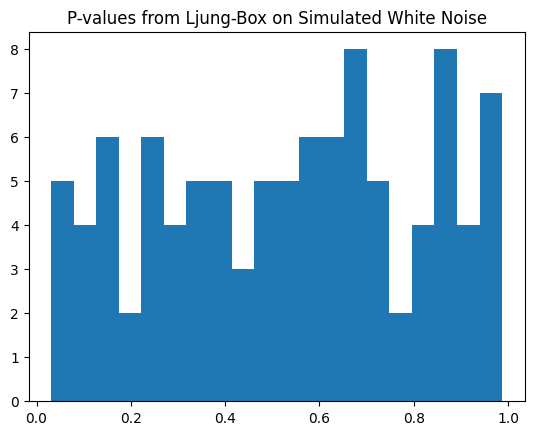

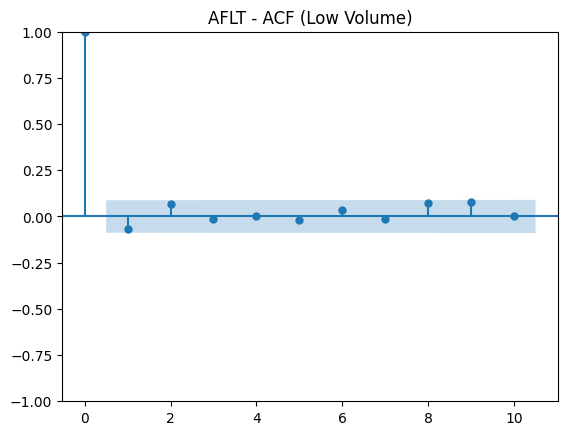

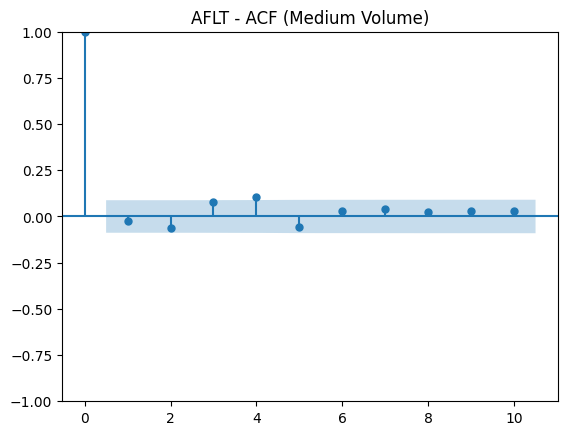

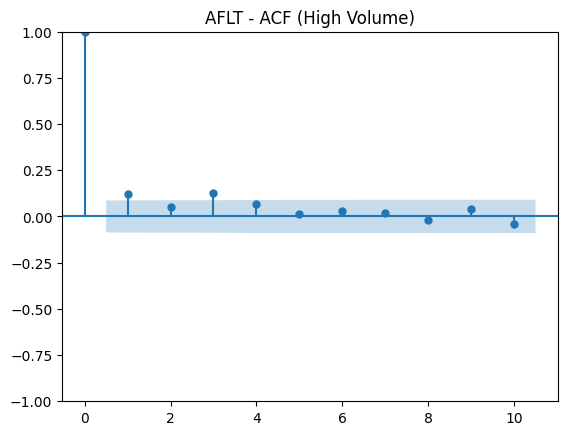

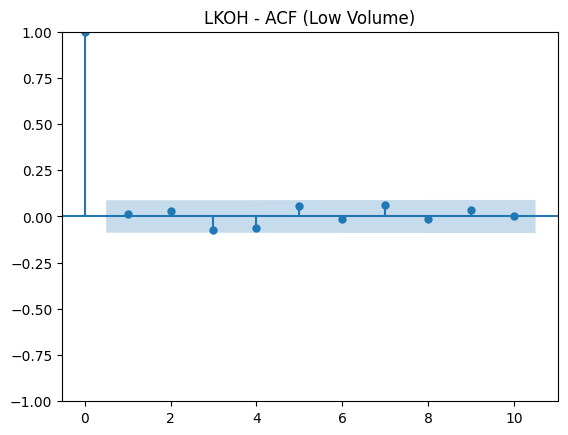

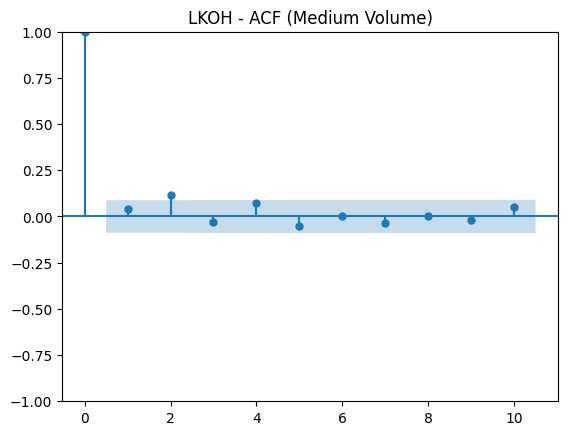

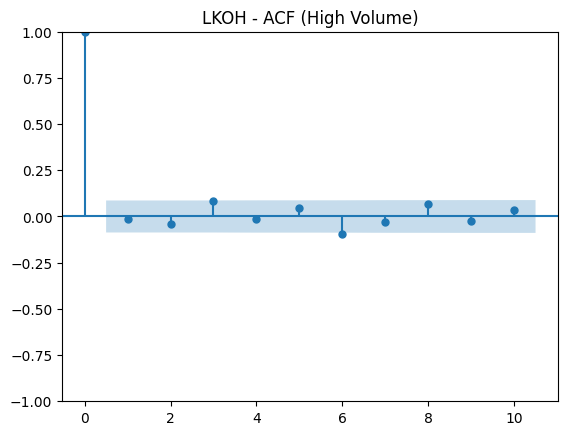

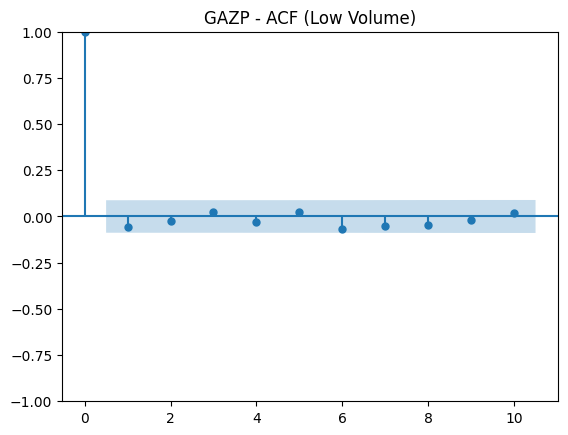

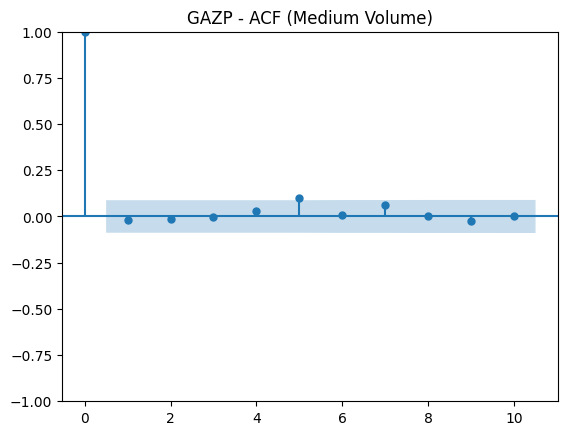

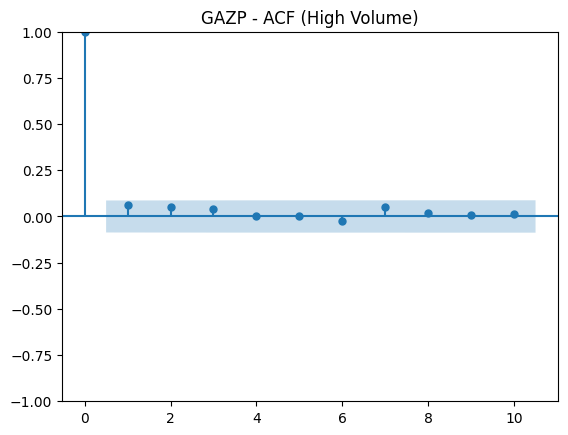

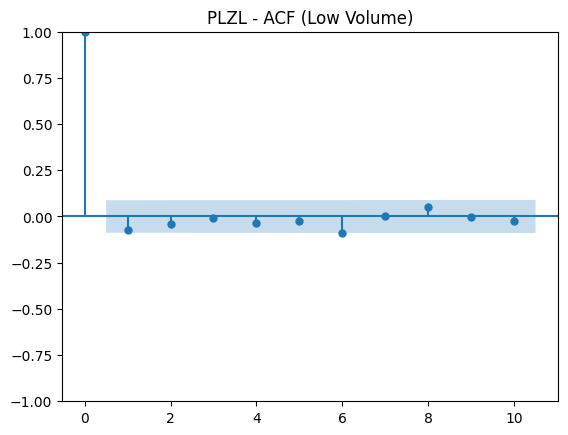

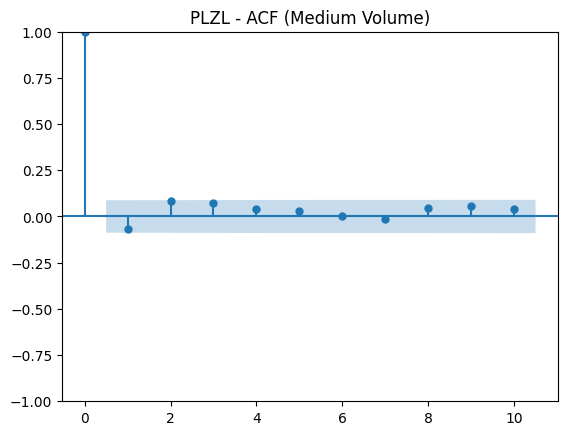

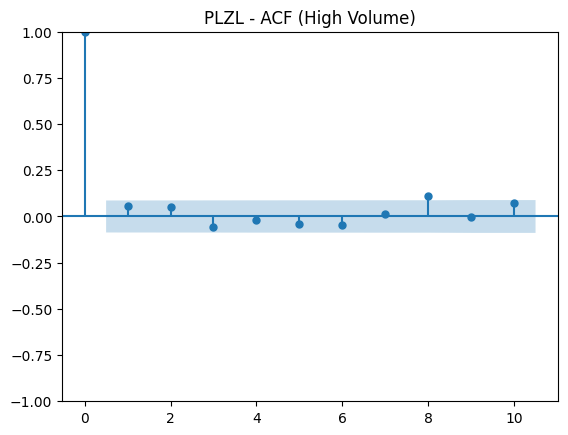

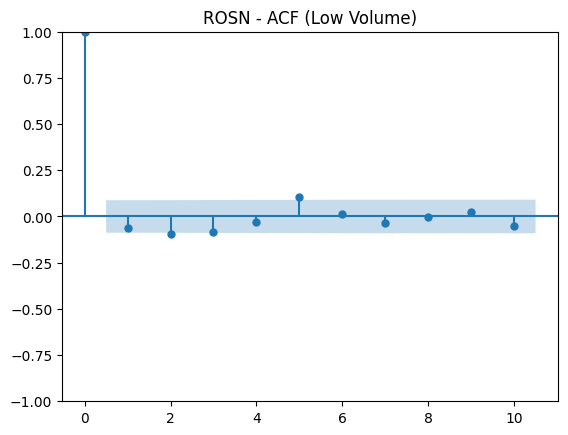

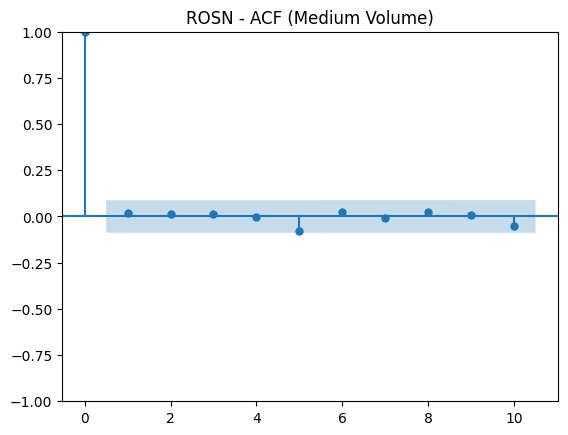

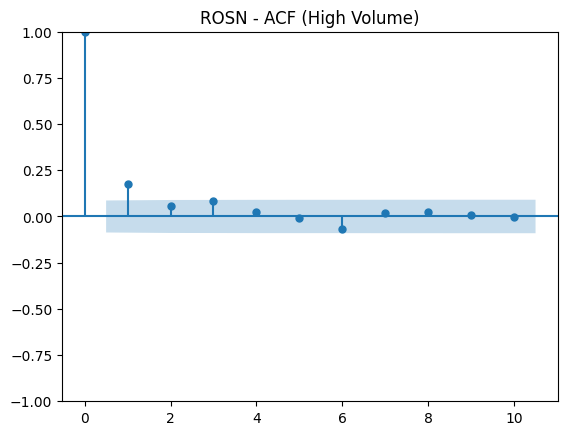

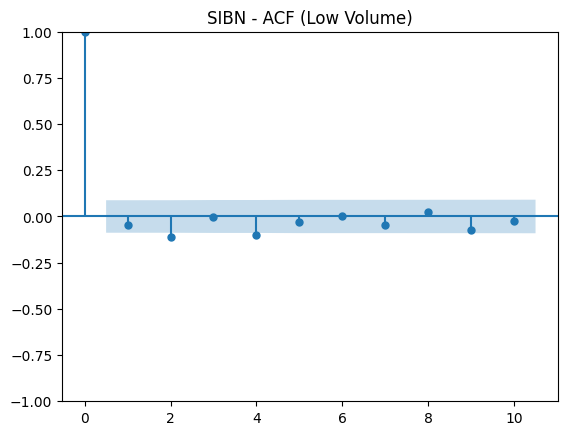

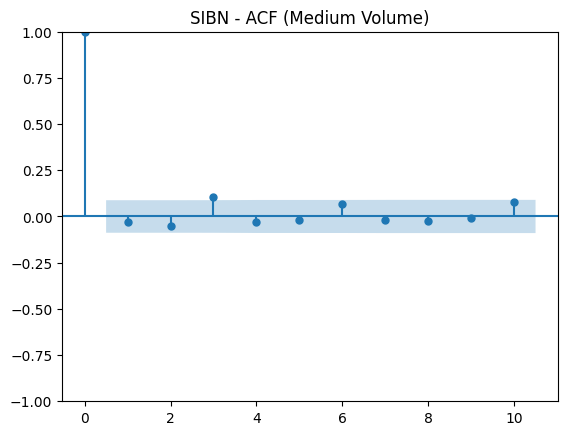

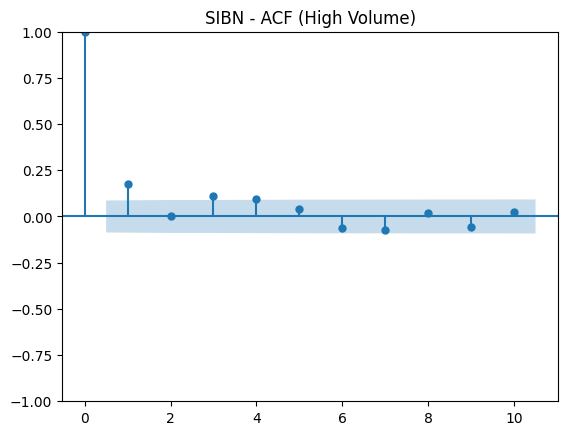

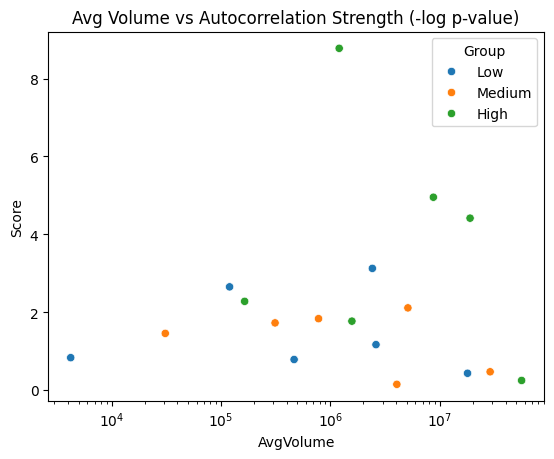

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import skew, kurtosis, kstest, chisquare
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller

tickers = ['AFLT','LKOH', 'GAZP', 'ZILL', 'PLZL', 'ROSN', 'YAKG', 'YKEN', 'LSNG', 'SIBN']
df = pd.DataFrame()

for ticker in tickers:
    df_temp = yf.download(ticker + '.ME', start='2015-01-01', end='2020-12-31', interval='1d')
    df_temp = df_temp.droplevel(1, axis=1)
    df_temp.columns.name = None
    df_temp = df_temp.reset_index()
    df_temp['Ticker'] = ticker
    df_temp = df_temp.drop(['High', 'Low', 'Open'], axis=1)
    df = pd.concat([df, df_temp])

try:
    df = df.drop(['Adj Close'], axis=1)
except:
    pass

df['Year'] = df.Date.dt.year
df_agg = df[(df.Volume!=0)].groupby(['Ticker', 'Year']).agg({'Date': 'count'}).reset_index()
df_agg2 = df_agg.groupby(['Ticker']).agg({'Date':'min'}).reset_index()
df = df[df.Ticker.isin(df_agg2[df_agg2.Date>240].Ticker.unique().tolist())]

df = df.sort_values(by=['Ticker', 'Date'])
df['LogReturn'] = df.groupby('Ticker')['Close'].transform(lambda x: np.log(x / x.shift(1)))
df = df.dropna()

df['PriceChangePct'] = np.exp(df['LogReturn']) - 1
df_eda = df.groupby(['Ticker', 'Year']).agg({'PriceChangePct':['max', 'min']})
df_eda = df_eda.reset_index()
df_eda.columns = ['Ticker', 'Year', 'PriceChangePct_max', 'PriceChangePct_min']
df_eda_min = df_eda.pivot(index='Ticker', columns='Year', values='PriceChangePct_min')
df_eda_max = df_eda.pivot(index='Ticker', columns='Year', values='PriceChangePct_max')


df['VolumeGroup'] = df.groupby('Ticker')['Volume'].transform(
    lambda x: pd.cut(x, 
                    bins=[-np.inf, x.quantile(0.33), x.quantile(0.66), np.inf],
                    labels=['Low', 'Medium', 'High'])
)

stats = df.groupby(['Ticker', 'VolumeGroup'])['LogReturn'].agg(['count', 'mean', 'std'])
stats['Skewness'] = df.groupby(['Ticker', 'VolumeGroup'])['LogReturn'].apply(skew)
stats['Kurtosis'] = df.groupby(['Ticker', 'VolumeGroup'])['LogReturn'].apply(kurtosis)

ks_results = []
chi2_results = []

for (ticker, group), subset in df.groupby(['Ticker', 'VolumeGroup']):
    returns = subset['LogReturn'].dropna()
    if len(returns) < 30:
        ks_results.append(np.nan)
        chi2_results.append(np.nan)
        continue

    mean = returns.mean()
    std = returns.std()

    # Kolmogorov-Smirnov test
    ks_stat, ks_p = kstest(returns, 'norm', args=(mean, std))
    ks_results.append(ks_p)

    # Chi-squared test
    observed, bins = np.histogram(returns, bins=10)
    expected = len(returns) * np.diff(norm.cdf(bins, loc=mean, scale=std))
    expected = expected * (observed.sum() / expected.sum())  # normalize
    chi_stat, chi_p = chisquare(f_obs=observed, f_exp=expected)
    chi2_results.append(chi_p)

# Add to stats DataFrame
stats['KS_pvalue'] = ks_results
stats['Chi2_pvalue'] = chi2_results

stats = stats.round({
    'KS_pvalue': 6,
    'Chi2_pvalue': 6
})

print(stats.round(4))

df_vol_corr['Score'] = -np.log(df_vol_corr['PValue'])

sns.scatterplot(data=df_vol_corr, x='AvgVolume', y='Score', hue='Group')
plt.xscale('log')
plt.title("Avg Volume vs Autocorrelation Strength (-log p-value)")


for ticker in df['Ticker'].unique():
    plt.figure(figsize=(12, 4))
    for group in ['Low', 'Medium', 'High']:
        sns.histplot(df[(df['Ticker'] == ticker) & (df['VolumeGroup'] == group)]['LogReturn'], 
                     kde=True, bins=30, label=group, alpha=0.6)
    plt.title(f"Log Return Distribution by Volume Group: {ticker}")
    plt.legend()
    plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='VolumeGroup', y='Volume')
plt.yscale('log')
plt.title('Volume Distribution by Volume Group (all tickers)')
plt.show()

vol_vs_vol = df.groupby(['Ticker', 'VolumeGroup']).agg(
    AvgVolume=('Volume', 'mean'),
    Volatility=('LogReturn', 'std')
).reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=vol_vs_vol, x='AvgVolume', y='Volatility', hue='VolumeGroup')
plt.title('Average Volume vs Return Volatility')
plt.xscale('log')
plt.show()

returns = df[df['Ticker'] == 'AFLT']['LogReturn'].dropna()
result = adfuller(returns)
print("ADF statistic:", result[0])
print("p-value:", result[1])

pvals = []
for _ in range(100):
    sample = np.random.normal(0, 0.01, 1000)
    p = acorr_ljungbox(sample, lags=[10], return_df=True)['lb_pvalue'].values[0]
    pvals.append(p)

plt.hist(pvals, bins=20)
plt.title("P-values from Ljung-Box on Simulated White Noise")
plt.show()

results = {}
for ticker in tickers:
    df_t = df[df['Ticker'] == ticker].copy()
    df_t['VolumeGroup'] = df_t['VolumeGroup'].astype(str)
    for group in ['Low', 'Medium', 'High']:
        sub = df_t[df_t['VolumeGroup'] == group]['LogReturn'].dropna()

        if len(sub) < 10:
            continue
        
        plot_acf(sub, lags=10)
        plt.title(f"{ticker} - ACF ({group} Volume)")
        plt.show()

        lb = acorr_ljungbox(sub, lags=[10], return_df=True)
        pval = lb['lb_pvalue'].values[0]

        results[(ticker, group)] = {
            'n': len(sub),
            'p': pval,
            'reject': pval < 0.05
        }

results_ = pd.DataFrame(results).T.reset_index()
results_.columns = ['Ticker', 'Volume', 'n', 'p_value', 'reject']
results_pivot = results_.pivot(index='Ticker', columns='Volume', values='p_value').reset_index()

data = []
for (ticker, group), res in results.items():
    avg_vol = df[(df['Ticker'] == ticker) & (df['VolumeGroup'] == group)]['Volume'].mean()
    data.append((ticker, group, avg_vol, res['reject'], res['p'], res['n']))

df_vol_corr = pd.DataFrame(data, columns=['Ticker', 'Group', 'AvgVolume', 'Reject', 'PValue', 'N'])
df_vol_corr['Score'] = -np.log(df_vol_corr['PValue'])

sns.scatterplot(data=df_vol_corr, x='AvgVolume', y='Score', hue='Group')
plt.xscale('log')
plt.title("Avg Volume vs Autocorrelation Strength (-log p-value)")
plt.show()


In [46]:
df.head()

,Date,Close,Volume,Ticker,Year,LogReturn,VolumeGroup
1,2015-01-06,22.027620,941330,AFLT,2015,-0.004224,Low
2,2015-01-08,23.426411,4139158,AFLT,2015,0.061567,Medium
3,2015-01-09,22.647083,5253679,AFLT,2015,-0.033833,Medium
4,2015-01-12,22.946825,3496773,AFLT,2015,0.013149,Low
5,2015-01-13,23.313173,3605124,AFLT,2015,0.015839,Low
